In [163]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import causal_convolution_layer
import Dataloader

In [164]:
import math
from torch.utils.data import DataLoader

In [165]:
class TransformerTimeSeries(torch.nn.Module):
    """
    Time Series application of transformers based on paper
    
    causal_convolution_layer parameters:
        in_channels: the number of features per time point
        out_channels: the number of features outputted per time point
        kernel_size: k is the width of the 1-D sliding kernel
        
    nn.Transformer parameters:
        d_model: the size of the embedding vector (input)
    
    PositionalEncoding parameters:
        d_model: the size of the embedding vector (positional vector)
        dropout: the dropout to be used on the sum of positional+embedding vector
    
    """
    def __init__(self):
        super(TransformerTimeSeries,self).__init__()
        self.input_embedding = causal_convolution_layer.context_embedding(2,256,9)
        self.positional_embedding = torch.nn.Embedding(512,256)

        
        self.decode_layer = torch.nn.TransformerEncoderLayer(d_model=256,nhead=8)
        self.transformer_decoder = torch.nn.TransformerEncoder(self.decode_layer, num_layers=3)
        
        self.fc1 = torch.nn.Linear(256,1)
        
    def forward(self,x,y,attention_masks):
        
        # concatenate observed points and time covariate
        # (B*feature_size*n_time_points)
        z = torch.cat((y.unsqueeze(1),x.unsqueeze(1)),1)

        # input_embedding returns shape (Batch size,embedding size,sequence len) -> need (sequence len,Batch size,embedding_size)
        z_embedding = self.input_embedding(z).permute(2,0,1)
        
        # get my positional embeddings (Batch size, sequence_len, embedding_size) -> need (sequence len,Batch size,embedding_size)
        positional_embeddings = self.positional_embedding(x.type(torch.long)).permute(1,0,2)
        
        input_embedding = z_embedding+positional_embeddings
        
        transformer_embedding = self.transformer_decoder(input_embedding,attention_masks)

        output = self.fc1(transformer_embedding.permute(1,0,2))
        
        return output
        

In [166]:
t0 = 48

In [167]:

train_dataset = Dataloader.time_series_decoder_paper(t0,4500)
validation_dataset = Dataloader.time_series_decoder_paper(t0,500)
test_dataset = Dataloader.time_series_decoder_paper(t0,1000)

x: 4500*72 fx: 4500*72
x: 500*72 fx: 500*72
x: 1000*72 fx: 1000*72


In [168]:
criterion = torch.nn.MSELoss()

In [169]:
train_dl = DataLoader(train_dataset,batch_size=32,shuffle=True)
validation_dl = DataLoader(validation_dataset,batch_size=64)
test_dl = DataLoader(test_dataset,batch_size=128)

In [170]:
model = TransformerTimeSeries().cuda()

In [171]:
lr = .0001 # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs = 60

In [172]:
def train_epoch(model,train_dl,t0=96):
    model.train()
    train_loss = 0
    n = 0
    for step,(x,y,attention_masks) in enumerate(train_dl):
        optimizer.zero_grad()
        output = model(x.cuda(),y.cuda(),attention_masks[0].cuda())
        loss = criterion(output.squeeze()[:,(t0-1):(t0+24-1)],y.cuda()[:,t0:]) 

        loss.backward()
        optimizer.step()
        
        train_loss += (loss.detach().cpu().item() * x.shape[0])
        n += x.shape[0]
    return train_loss/n

In [173]:
def eval_epoch(model,validation_dl,t0=96):
    model.eval()
    eval_loss = 0
    n = 0
    with torch.no_grad():
        for step,(x,y,attention_masks) in enumerate(validation_dl):
            output = model(x.cuda(),y.cuda(),attention_masks[0].cuda())
            loss = criterion(output.squeeze()[:,(t0-1):(t0+24-1)],y.cuda()[:,t0:]) 
            
            eval_loss += (loss.detach().cpu().item() * x.shape[0])
            n += x.shape[0]
            
    return eval_loss/n

In [174]:
train_epoch_loss = []
eval_epoch_loss = []
for e,epoch in enumerate(range(epochs)):
    train_loss = []
    eval_loss = []
    
    l_t = train_epoch(model,train_dl,t0)
    train_loss.append(l_t)
    
    l_e = eval_epoch(model,validation_dl,t0)
    eval_loss.append(l_e)
    
        
    train_epoch_loss.append(np.mean(train_loss))
    eval_epoch_loss.append(np.mean(eval_loss))
    
    print("Epoch {}: Train loss: {} \t Validation loss: {} ".format(e,
                                                             np.mean(train_loss),
                                                             np.mean(eval_loss)))

Epoch 0: Train loss: 4748.951652777778 	 Validation loss: 4419.00246484375 
Epoch 1: Train loss: 4249.097079644097 	 Validation loss: 3947.675669921875 
Epoch 2: Train loss: 3770.66015234375 	 Validation loss: 3470.705953125 
Epoch 3: Train loss: 3301.400733072917 	 Validation loss: 3015.414421875 
Epoch 4: Train loss: 2861.422865451389 	 Validation loss: 2597.228880859375 
Epoch 5: Train loss: 2463.2560345052084 	 Validation loss: 2225.004458984375 
Epoch 6: Train loss: 2113.76243999566 	 Validation loss: 1903.4614501953124 
Epoch 7: Train loss: 1816.1272916666667 	 Validation loss: 1634.2106064453126 
Epoch 8: Train loss: 1570.6483754340277 	 Validation loss: 1416.103462890625 
Epoch 9: Train loss: 1354.4440113932292 	 Validation loss: 1126.21137109375 
Epoch 10: Train loss: 1056.502272515191 	 Validation loss: 912.779623046875 
Epoch 11: Train loss: 859.5210262586805 	 Validation loss: 739.3005629882813 
Epoch 12: Train loss: 697.1796413845486 	 Validation loss: 595.6631352539063 
E

## Visualize the data

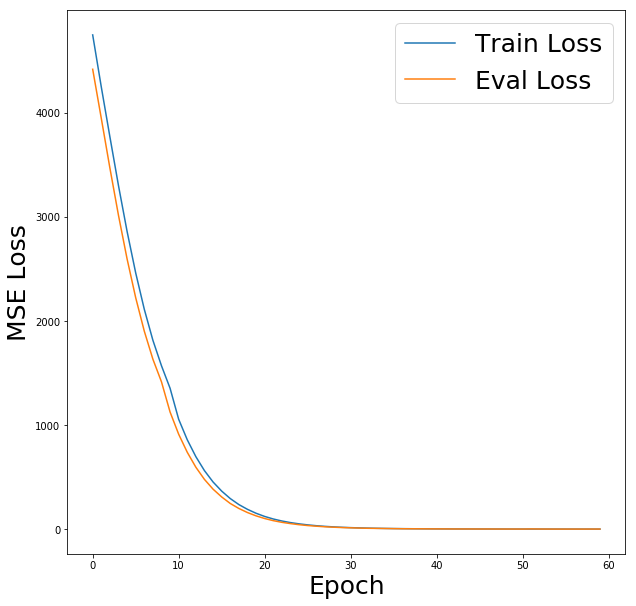

In [175]:
plt.figure(figsize=(10,10))
plt.plot(train_epoch_loss)
plt.plot(eval_epoch_loss)
plt.legend(['Train Loss','Eval Loss'],fontsize=25)
plt.xlabel("Epoch",fontsize=25)
plt.ylabel("MSE Loss",fontsize=25)
plt.show()

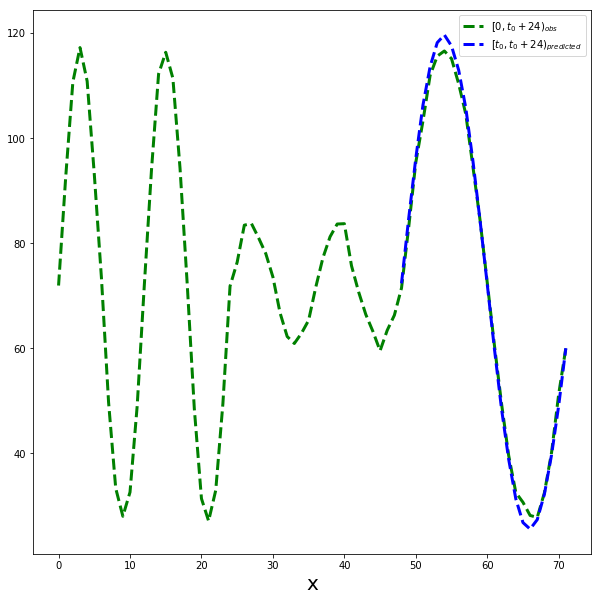

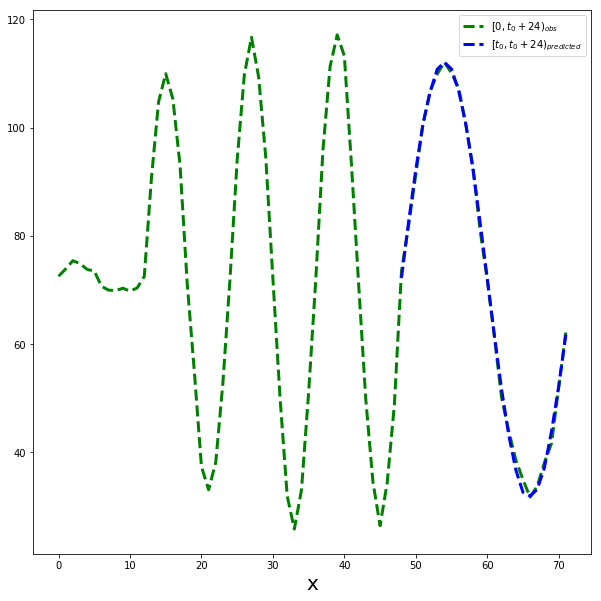

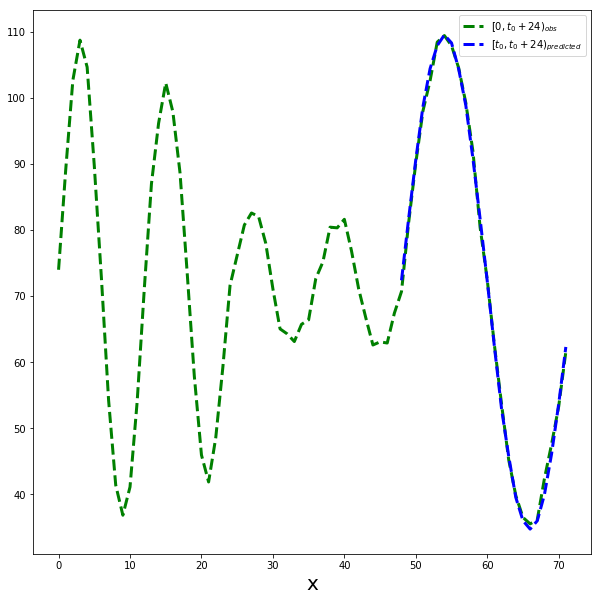

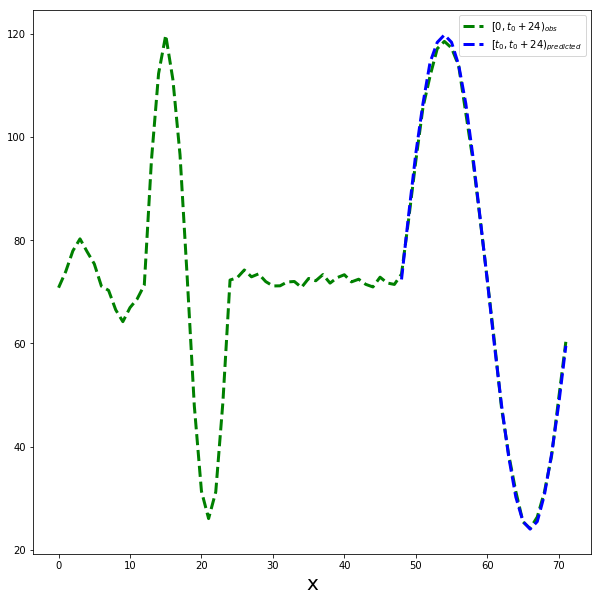

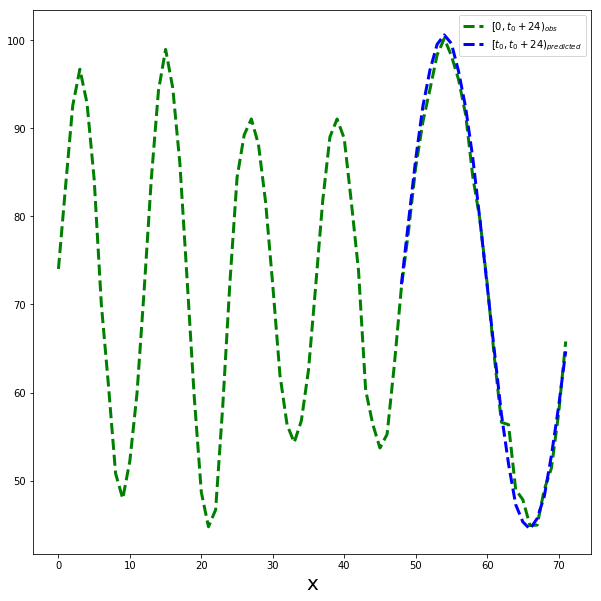

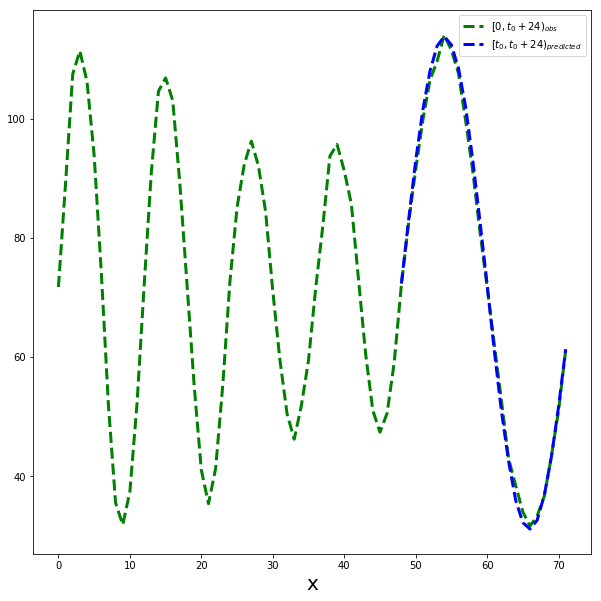

In [176]:
n_plots = 5
with torch.no_grad():
    model.eval()
    for step,(x,y,attention_masks) in enumerate(test_dl):
            output = model(x.cuda(),y.cuda(),attention_masks[0].cuda())

            if step > n_plots:
                break

            with torch.no_grad():
                plt.figure(figsize=(10,10))
                plt.plot(x[0].cpu().detach().squeeze().numpy(),y[0].cpu().detach().squeeze().numpy(),'g--',linewidth=3)
                plt.plot(x[0,t0:].cpu().detach().squeeze().numpy(),output[0,(t0-1):(t0+24-1)].cpu().detach().squeeze().numpy(),'b--',linewidth=3) 
        
                plt.xlabel("x",fontsize=20)
                plt.legend(["$[0,t_0+24)_{obs}$","$[t_0,t_0+24)_{predicted}$"])
                plt.show()


In [177]:
def get_attn(model,x,y,attention_masks):
    model.eval()
    with torch.no_grad():
        x=x.cuda(); y=y.cuda(); attention_masks = attention_masks.cuda()
        z = torch.cat((y.unsqueeze(1),x.unsqueeze(1)),1)
        z_embedding = model.input_embedding(z).permute(2,0,1)
        positional_embeddings = model.positional_embedding(x.type(torch.long)).permute(1,0,2)
        input_embedding = z_embedding+positional_embeddings
                
        attn_layer_i = []
        for layer in model.transformer_decoder.layers:
            attn_layer_i.append(layer.self_attn(input_embedding,input_embedding,input_embedding,attn_mask=attention_masks)[-1].squeeze().cpu().detach().numpy())
            input_embedding = layer.forward(input_embedding,attention_masks)
        
        return attn_layer_i

In [178]:
idx_example = 5

In [179]:
attn_layers = get_attn(model,test_dataset[idx_example][0].unsqueeze(0),test_dataset[idx_example][1].unsqueeze(0),test_dataset[idx_example][2])

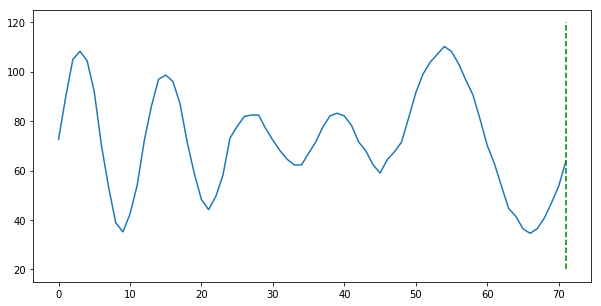

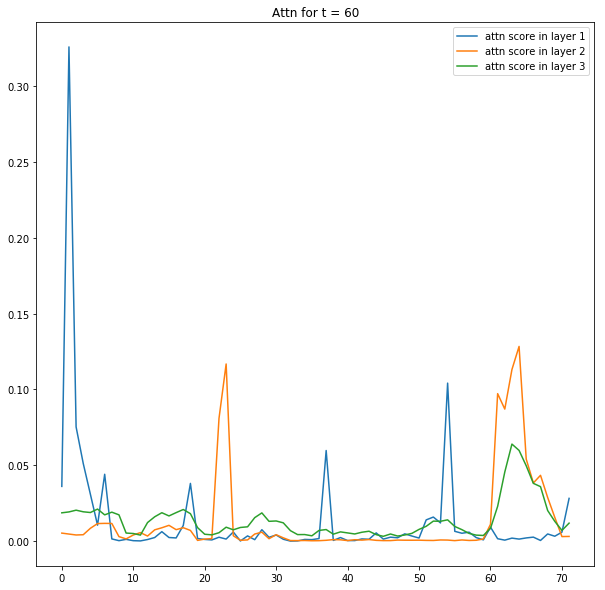

In [180]:
plt.figure(figsize=(10,5))
plt.plot(test_dataset[idx_example][0].numpy(),train_dataset[10][1].numpy())
plt.plot([t0+24-1,t0+24-1],[20,120],'g--')
plt.figure(figsize=(10,10))
plt.plot(attn_layers[0][t0+24-1]) 
plt.plot(attn_layers[1][t0+24-1]) 
plt.plot(attn_layers[2][t0+24-1]) 



plt.legend(["attn score in layer 1","attn score in layer 2","attn score in layer 3"])
plt.title("Attn for t = 60") 

plt.show()